# Getting Started with the Mini Wheelbot Dataset


## Step 1: Download the data

The `wheelbot-dataset` package directly provides you with the functionality to download all the data directly from Zonodo.


In [ ]:
from wheelbot_dataset import download_dataset

data_pwd = "data"

# this will directly download the dataset from https://zenodo.org/records/18234245 a folder named 'data'
download_dataset(output_dir=data_pwd)

## Step 1: Load the data

After downloading the dataset, you can simply load it via the `wheelbot-dataset` API.
The dataset is organized into a three-tiered hierarchy, designed to make it easy to manage both large batches of data and individual sensor readings.

### 1. Dataset (The Root)

The `Dataset` is the top-level container. It represents your entire data directory. When initialized, it automatically scans all sub-folders and organizes them into **Experiment Groups**.

- **Maps to:** Your root project folder.
- **Key Role:** Acts as the entry point for loading all your data at once.

### 2. ExperimentGroup (The Category)

An `ExperimentGroup` is a container for multiple experiments of the same type (e.g., all trials within a folder named `yaw_circle`).

- **Maps to:** A specific sub-directory.
- **Key Role:** Allows you to perform "batch" operations, such as applying a filter or resampling data across every trial in that group simultaneously.
- **Access:** Behaves like a list; you can iterate through it or access specific trials by index (e.g., `group[0]`).

### 3. Experiment (The Single Trial)

The `Experiment` is the fundamental unit. Each experiment represents one specific test run and is automatically built from a matching pair of files:

- **`.data` (Timeseries):** A `pandas.DataFrame` containing the actual sensor values (e.g., torque, velocity), with the time column set as the index.
- **`.meta` (Metadata):** A `dict` containing the "context" of the test (e.g., robot ID, hardware version, or experiment success status).
- **Key Role:** Handles specific data cleaning tasks like trimming time, resampling, or exporting data to NumPy arrays.


In [2]:
from wheelbot_dataset import Dataset

# Load a dataset
ds = Dataset(data_pwd)

# Dataset contains folders as groups
group = ds.load_group("yaw_circle")

# Groups contain lists of experiments
exp = group[0]
print(exp.data.head())

          /gyro0/x  /gyro0/y  /gyro0/z  /gyro1/x  /gyro1/y  /gyro1/z  \
_time                                                                  
0.000000  0.004522 -0.001064 -0.010108  0.003192 -0.008246 -0.001064   
0.001012  0.005320 -0.001862  0.001862  0.001330 -0.006384  0.001064   
0.002012  0.003990 -0.002660 -0.002926 -0.002394 -0.004522  0.005852   
0.003013  0.000532 -0.006384 -0.005852 -0.003192 -0.005586  0.004256   
0.004011  0.001596 -0.007448 -0.006384 -0.004788 -0.011172 -0.001064   

          /gyro2/x  /gyro2/y  /gyro2/z  /gyro3/x  ...  \
_time                                             ...   
0.000000  0.002394  0.002394  0.004522 -0.006650  ...   
0.001012  0.002394  0.002394  0.004522 -0.001862  ...   
0.002012  0.006916  0.010374  0.000532 -0.001064  ...   
0.003013  0.003192  0.011970 -0.000798  0.000532  ...   
0.004011 -0.001330  0.008246  0.001862 -0.000532  ...   

          /setpoint/balancing_wheel_angle  \
_time                                       
0.000

The meta data contains the "context" of the experiment (e.g., robot ID, surface of the experiment, or experiment success status).
This may be used for applications such as contextual dynamics learning or time series classification tasks.


In [3]:
print(exp.meta)

{'experiment_status': 'success', 'wheelbot': 'wheelbot-beta-2', 'surface': 'concrete', 'uuid': '0fd9f740-a9ff-4cab-85e1-5cba699a42c1'}


## Step 2: Process the data

Once the data is loaded, you can manipulate it at different levels of the hierarchy using built-in processing methods.
Most operations return a **new** instance, leaving the original data untouched.


In [4]:
# Remove before standup and standup, lay down and after laydown from experiment
exp_cut = exp.cut_by_condition(
    start_condition=lambda df: df["/tau_DR_command/reaction_wheel"].abs() > 0,
    end_condition=lambda df: df["/tau_DR_command/reaction_wheel"].abs() == 0,
).cut_time(start=2.0, end=2.0)

You can also implement your costum filters:


In [5]:
import scipy.signal as signal


def lowpass_filter(df):
    b, a = signal.butter(4, 2 * 50 / 1000, btype="low")
    df_filtered = df.copy()
    for col in df.columns:
        df_filtered[col] = signal.filtfilt(b, a, df[col])
    return df_filtered


exp_filtered = exp_cut.apply_filter(lowpass_filter).resample(dt=0.01)

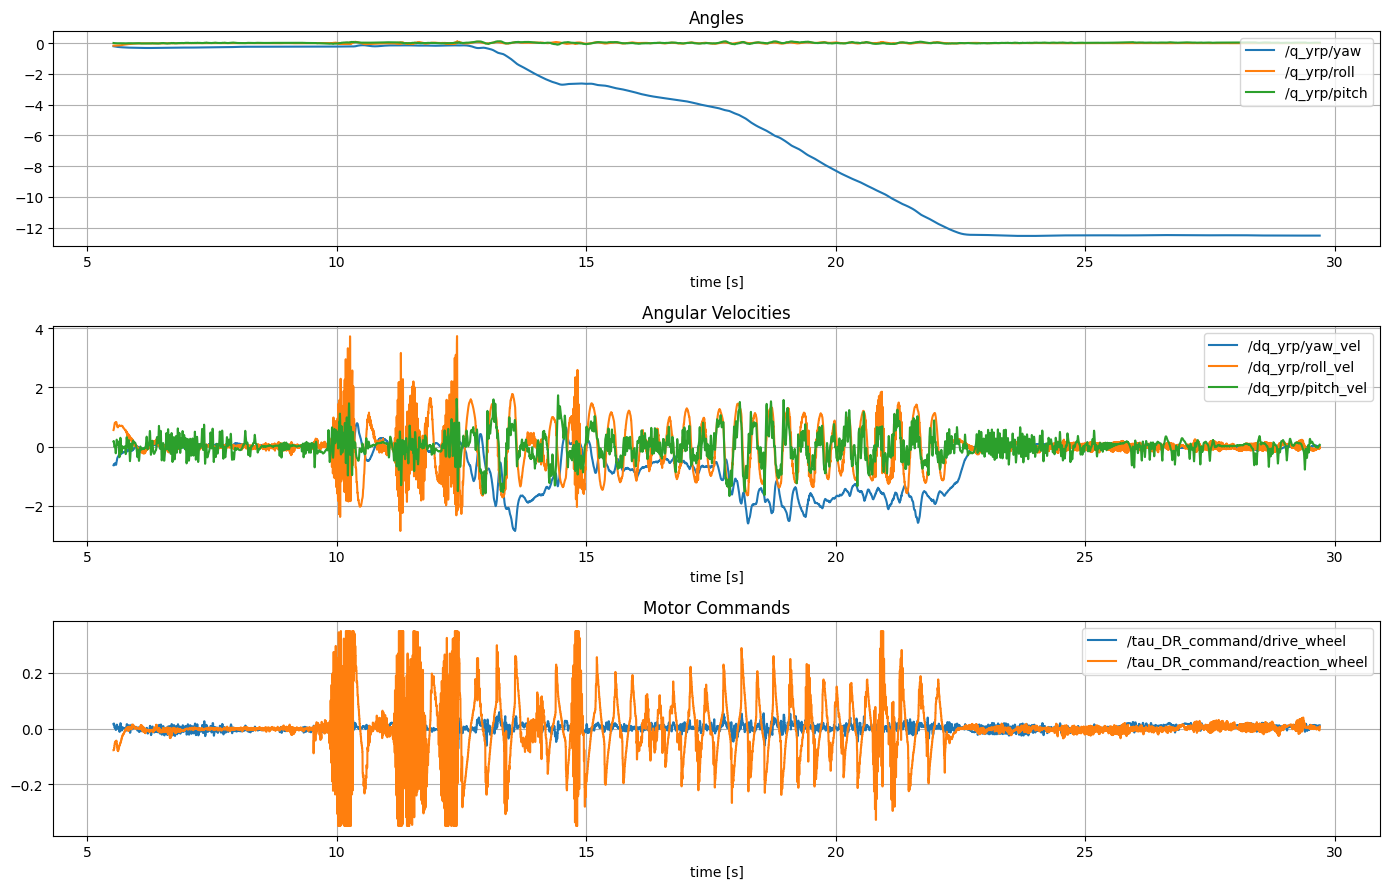

In [6]:
import matplotlib.pyplot as plt

from wheelbot_dataset import plot_timeseries

# Plot an experiment
plot_fields = {
    "Gyro 0": ["/gyro0/x", "/gyro0/y", "/gyro0/z"],
    "Gyro 1": ["/gyro1/x", "/gyro1/y", "/gyro1/z"],
    "Gyro 2": ["/gyro2/x", "/gyro2/y", "/gyro2/z"],
    "Gyro 3": ["/gyro3/x", "/gyro3/y", "/gyro3/z"],
    "Accel 0": ["/accel0/x", "/accel0/y", "/accel0/z"],
    "Accel 1": ["/accel1/x", "/accel1/y", "/accel1/z"],
    "Accel 2": ["/accel2/x", "/accel2/y", "/accel2/z"],
    "Accel 3": ["/accel3/x", "/accel3/y", "/accel3/z"],
    "YPR": ["/q_yrp/yaw", "/q_yrp/roll", "/q_yrp/pitch"],
    "YPR Vel": ["/dq_yrp/yaw_vel", "/dq_yrp/roll_vel", "/dq_yrp/pitch_vel"],
    "Wheel Position": ["/q_DR/drive_wheel", "/q_DR/reaction_wheel"],
    "Wheel Velocity": ["/dq_DR/drive_wheel", "/dq_DR/reaction_wheel"],
    "Wheel Acceleration": ["/ddq_DR/drive_wheel", "/ddq_DR/reaction_wheel"],
    "Commands": ["/tau_DR_command/drive_wheel", "/tau_DR_command/reaction_wheel"],
    "Setpoint Euler": ["/setpoint/yaw", "/setpoint/roll", "/setpoint/pitch"],
    "Setpoint Rates": [
        "/setpoint/yaw_rate",
        "/setpoint/roll_rate",
        "/setpoint/pitch_rate",
    ],
    "Setpoint Wheels": [
        "/setpoint/driving_wheel_angle",
        "/setpoint/driving_wheel_angular_velocity",
        "/setpoint/balancing_wheel_angle",
        "/setpoint/balancing_wheel_angular_velocity",
    ],
    "Vicon Position": ["/vicon_position/x", " /vicon_position/y", "/vicon_position/z"],
    "Battery": ["battery_voltage"],
}

# Specify a subset of variable to plot
plot_fields_to_plot = {
    "Angles": ["/q_yrp/yaw", "/q_yrp/roll", "/q_yrp/pitch"],
    "Angular Velocities": ["/dq_yrp/yaw_vel", "/dq_yrp/roll_vel", "/dq_yrp/pitch_vel"],
    "Motor Commands": ["/tau_DR_command/drive_wheel", "/tau_DR_command/reaction_wheel"],
}

plot_timeseries(experiments=exp_cut, groups=plot_fields_to_plot, save_fig=False)

Filtered experiment:


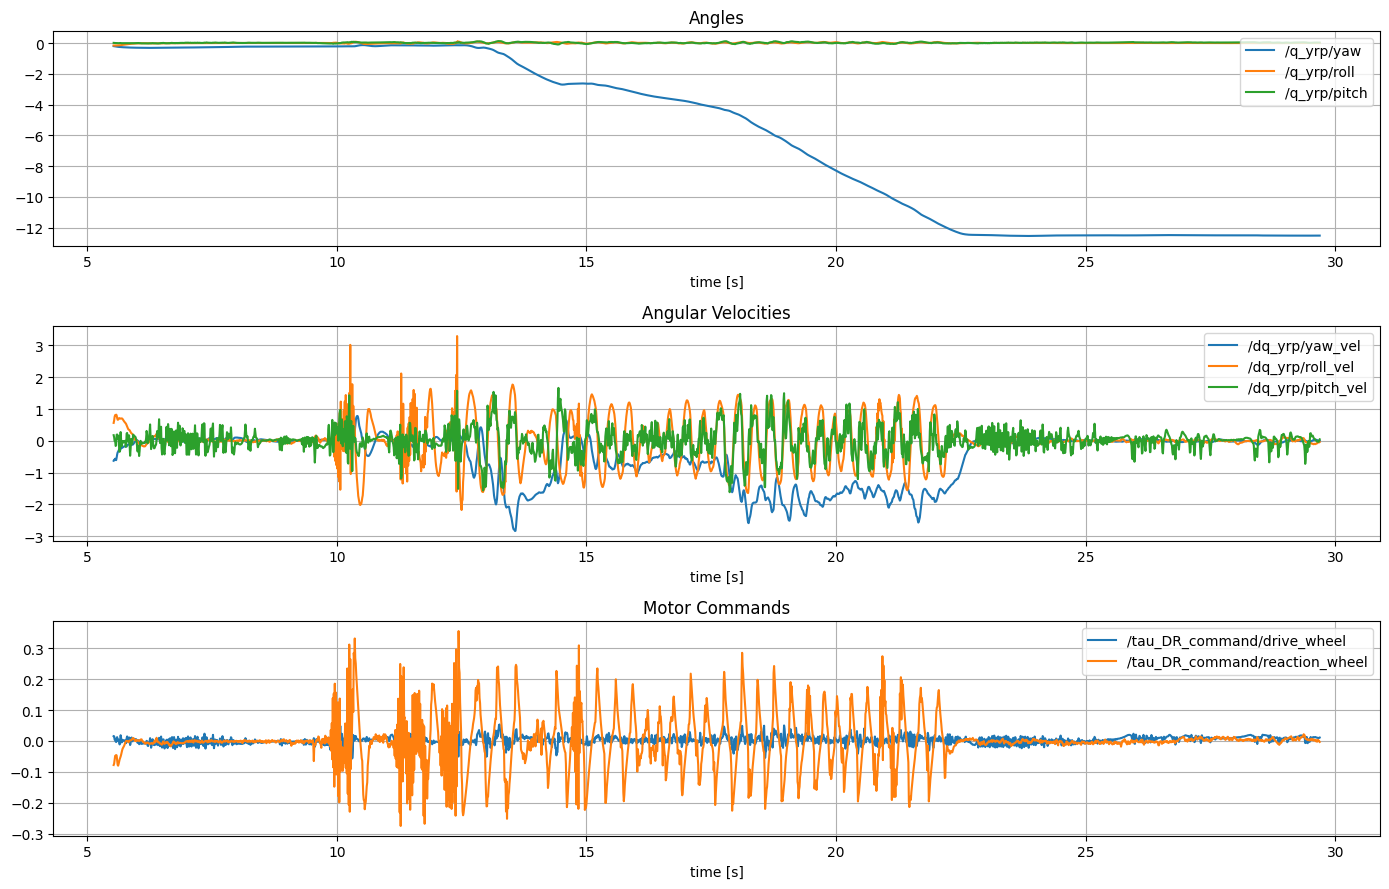

In [7]:
plot_timeseries(experiments=exp_filtered, groups=plot_fields_to_plot, save_fig=False)

## 3. Batch Processing

Instead of applying the filter manually to each experiment, you can also process the experiments in batches.


In [ ]:
DT = 0.01


# Define the same filters for all experiments in a group or dataset
def cut_and_filter_fn(exp):
    return (
        exp.cut_by_condition(
            start_condition=lambda df: df["/tau_DR_command/reaction_wheel"].abs() > 0,
            end_condition=lambda df: df["/tau_DR_command/reaction_wheel"].abs() == 0,
        )
        .cut_time(start=2.0, end=2.0)
        .apply_filter(lowpass_filter)
        .resample(dt=DT)
    )

### Apply filter function to a group

filter_by_metadata needs to be applied separately


In [9]:
# filter_by_metadata needs to be applied separately or as the last filter (inefficient)
group_filtered = group.map(
    lambda exp: exp.filter_by_metadata(experiment_status="success")
).map(cut_and_filter_fn)

### Apply filter function to an entire dataset

You can also just map generic lambdas that remove experiments by returning `None`.


In [10]:
ds_filtered = (
    ds.map(lambda exp: exp.filter_by_metadata(experiment_status="success"))
    .map(cut_and_filter_fn)
    .map(lambda exp: exp if "battery/voltage" in exp.data.columns else None)
)

### Visualize data as histogram to gain intution about the distribution


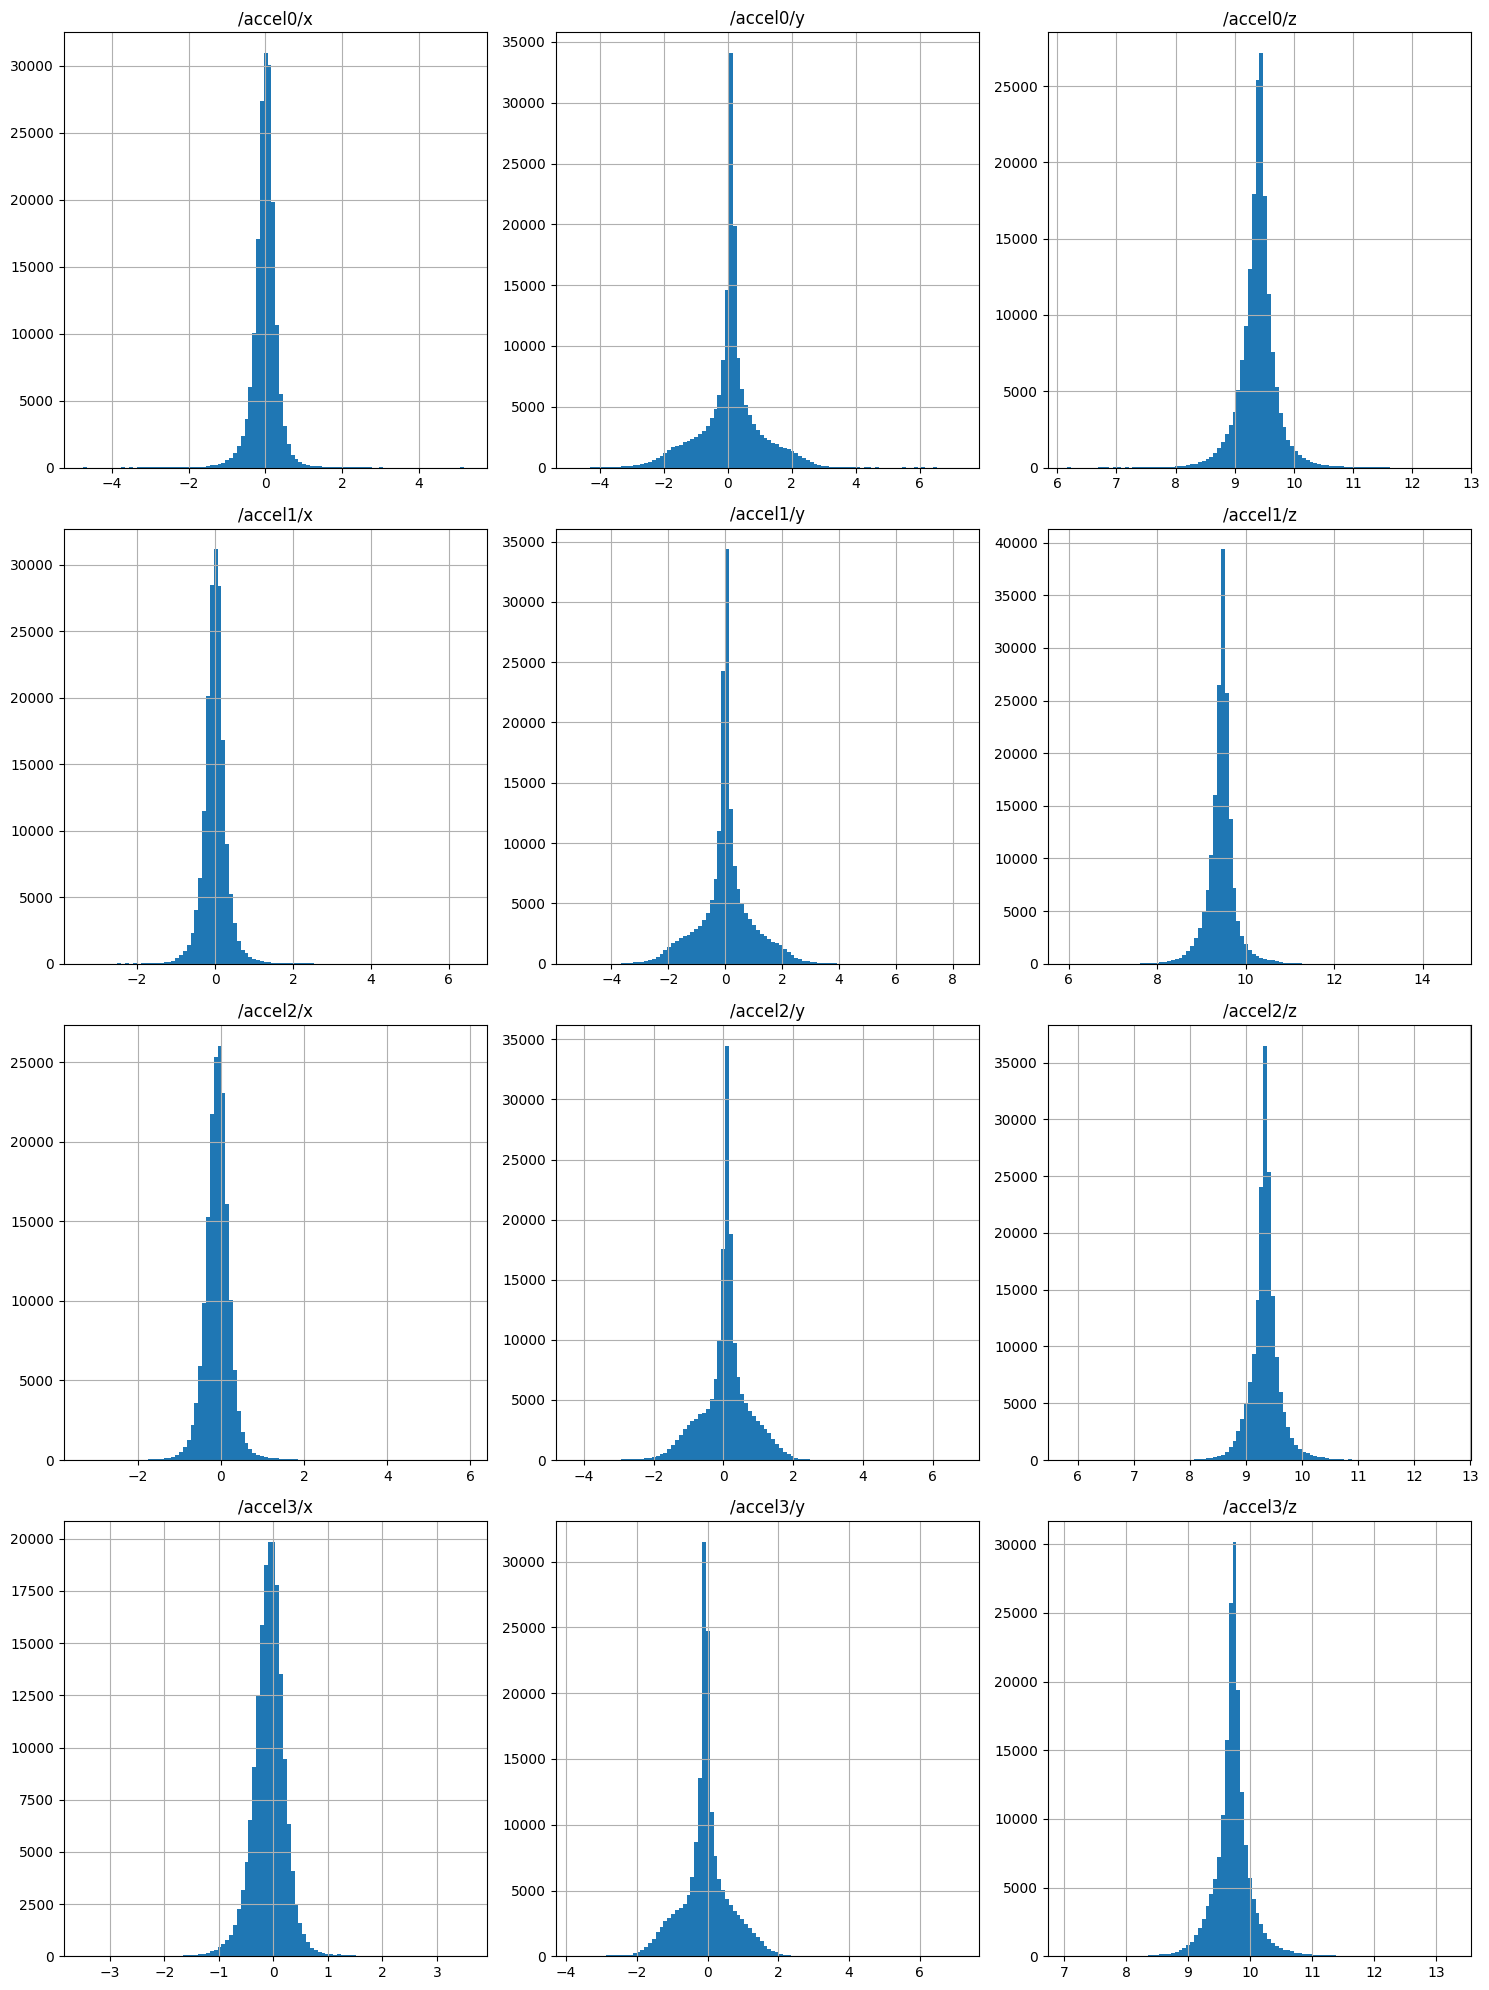

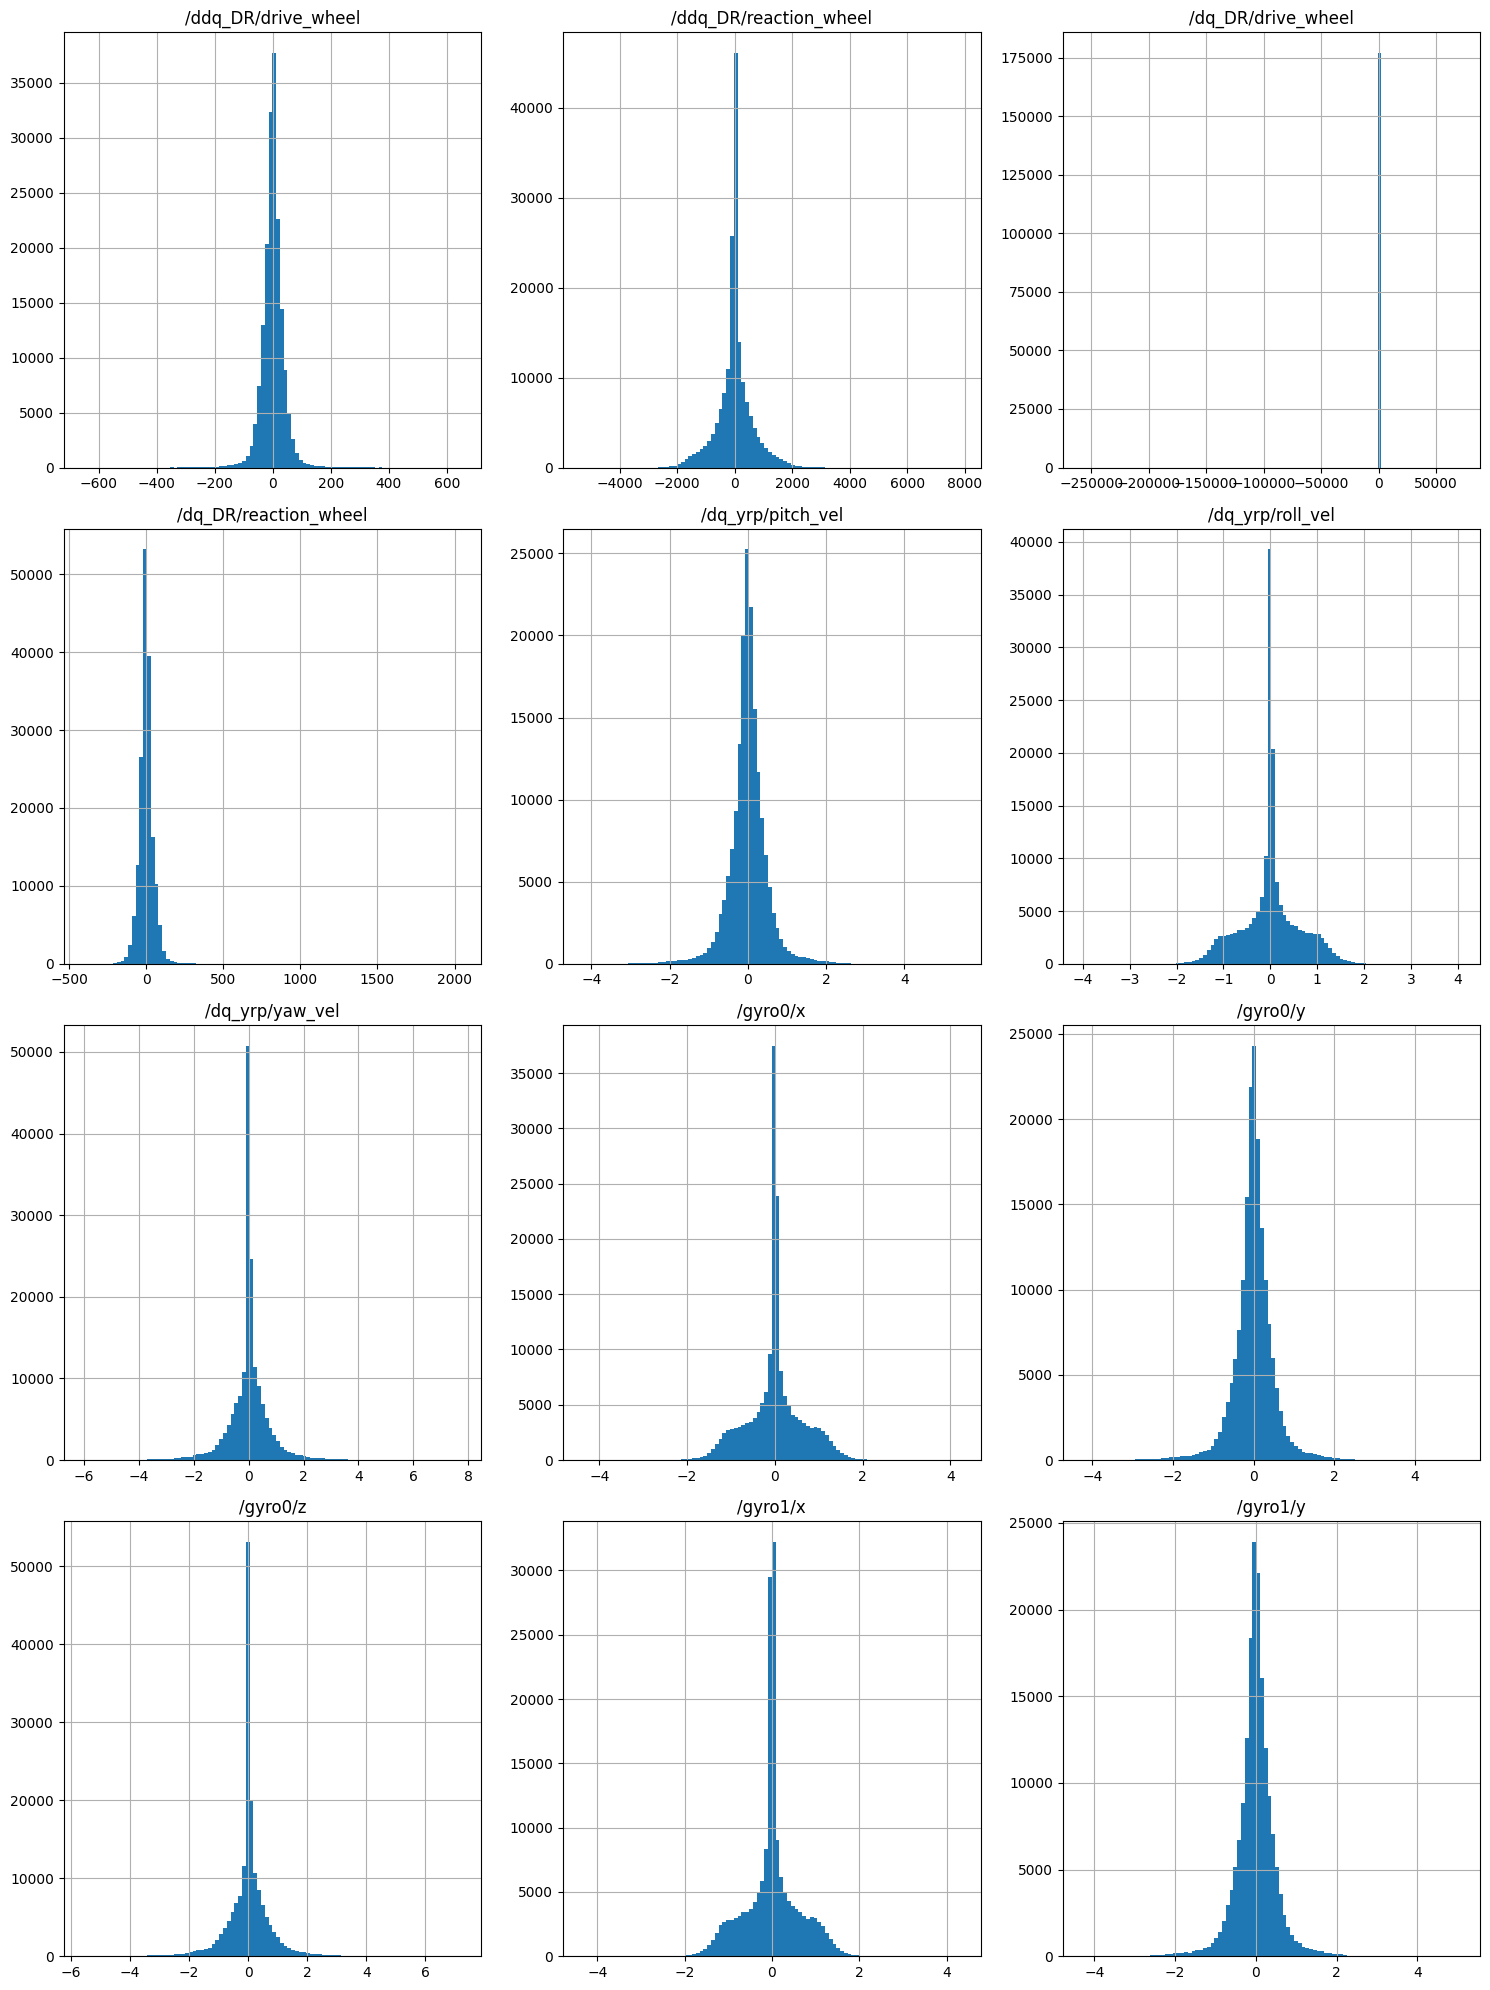

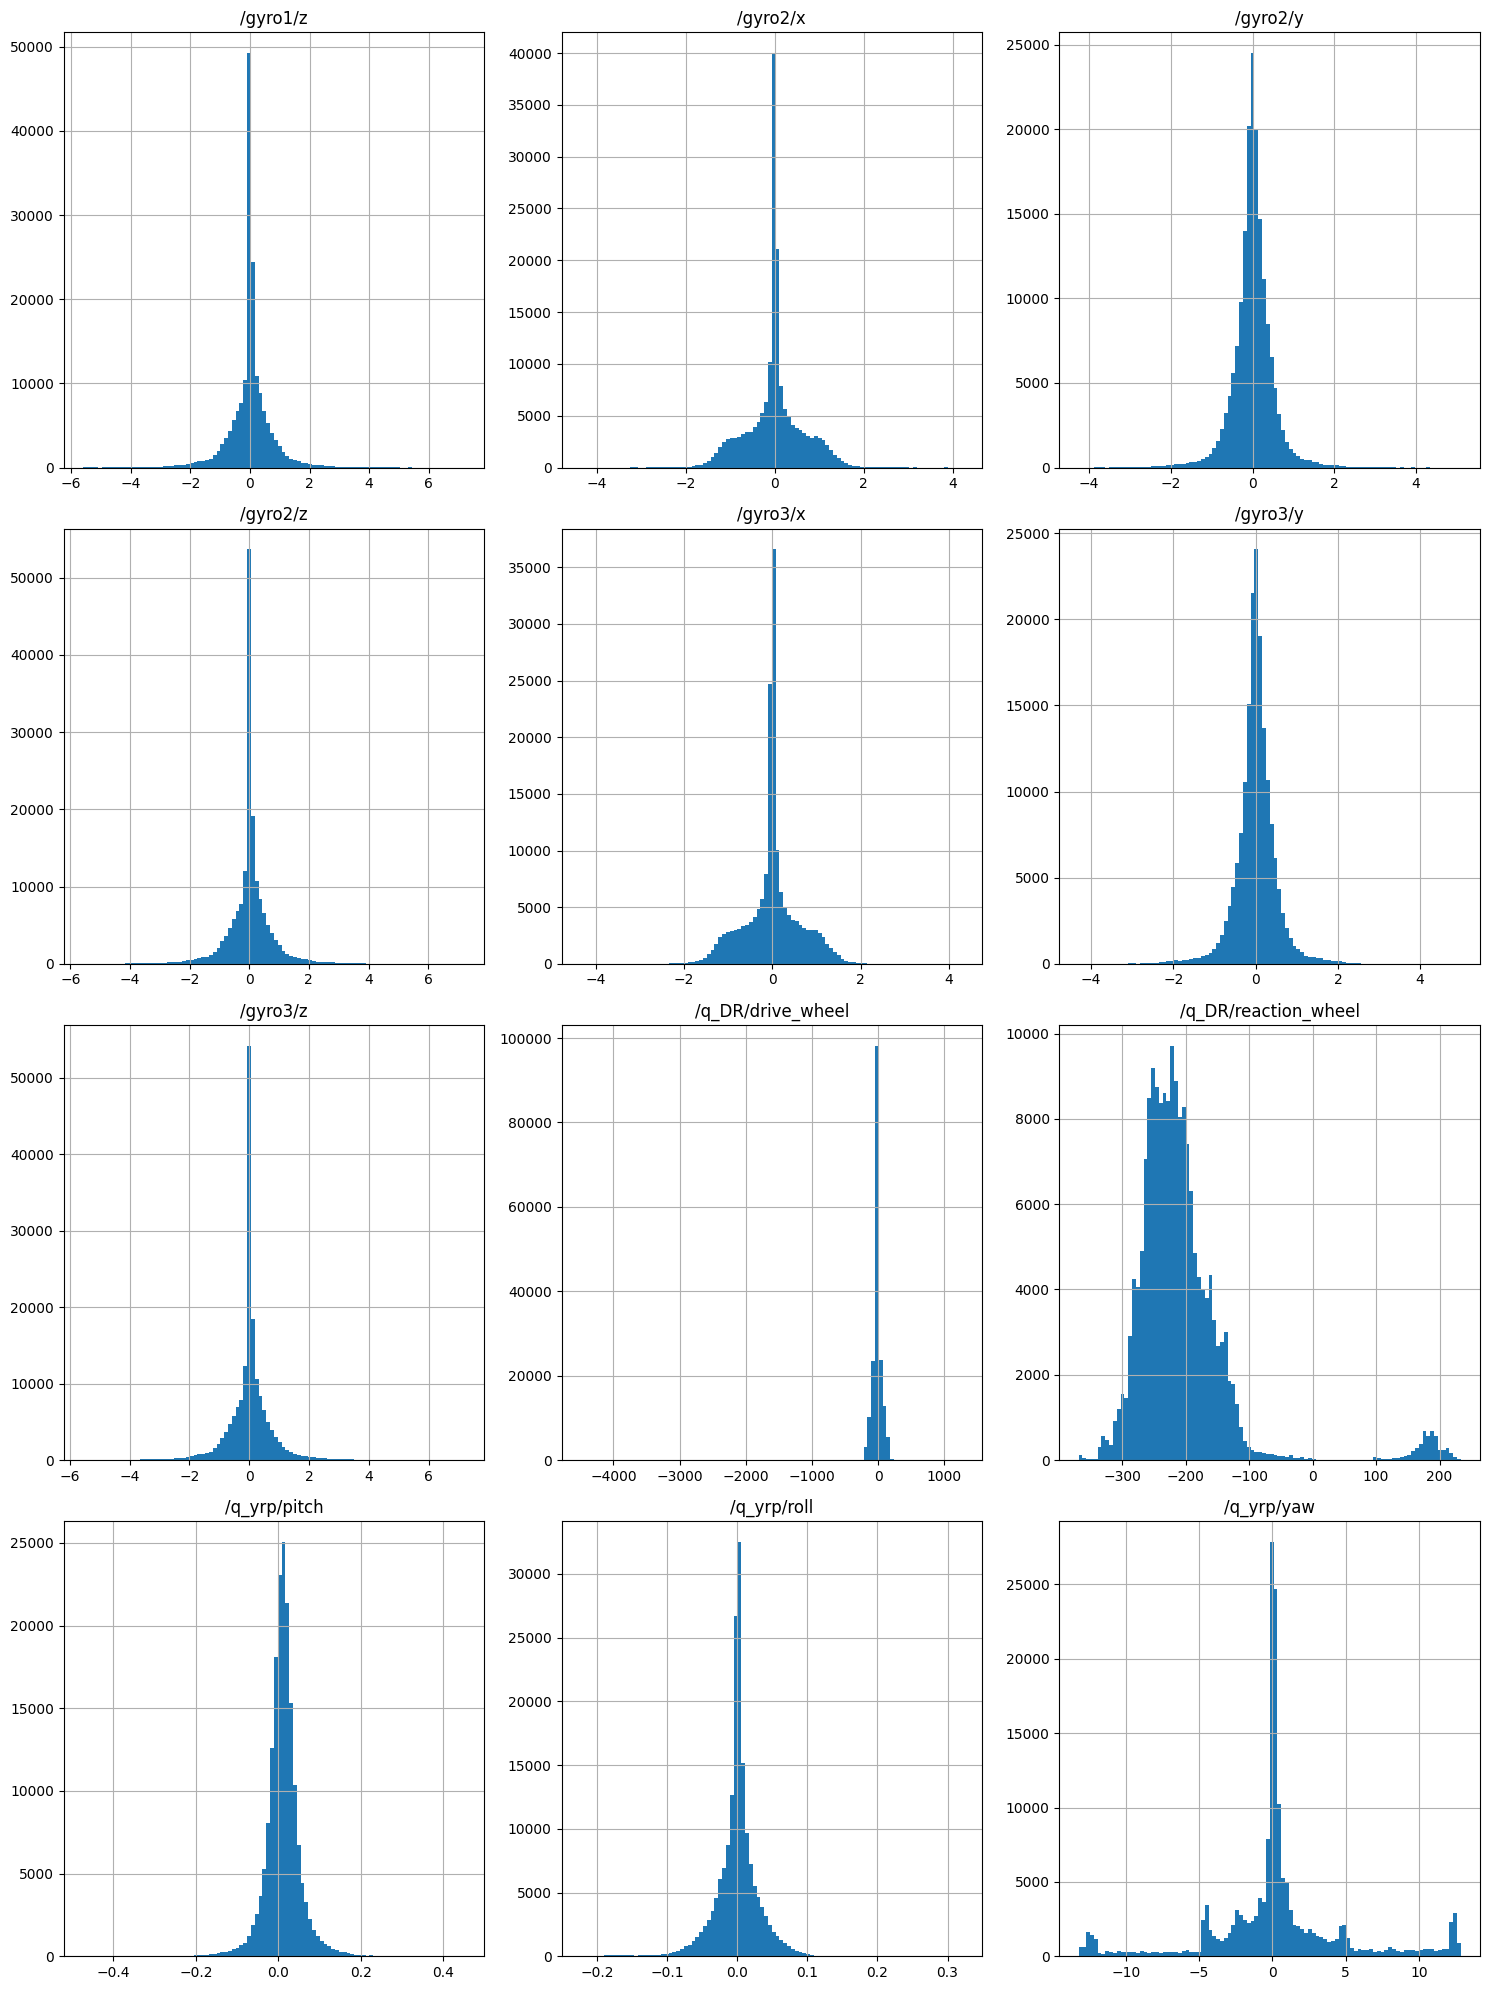

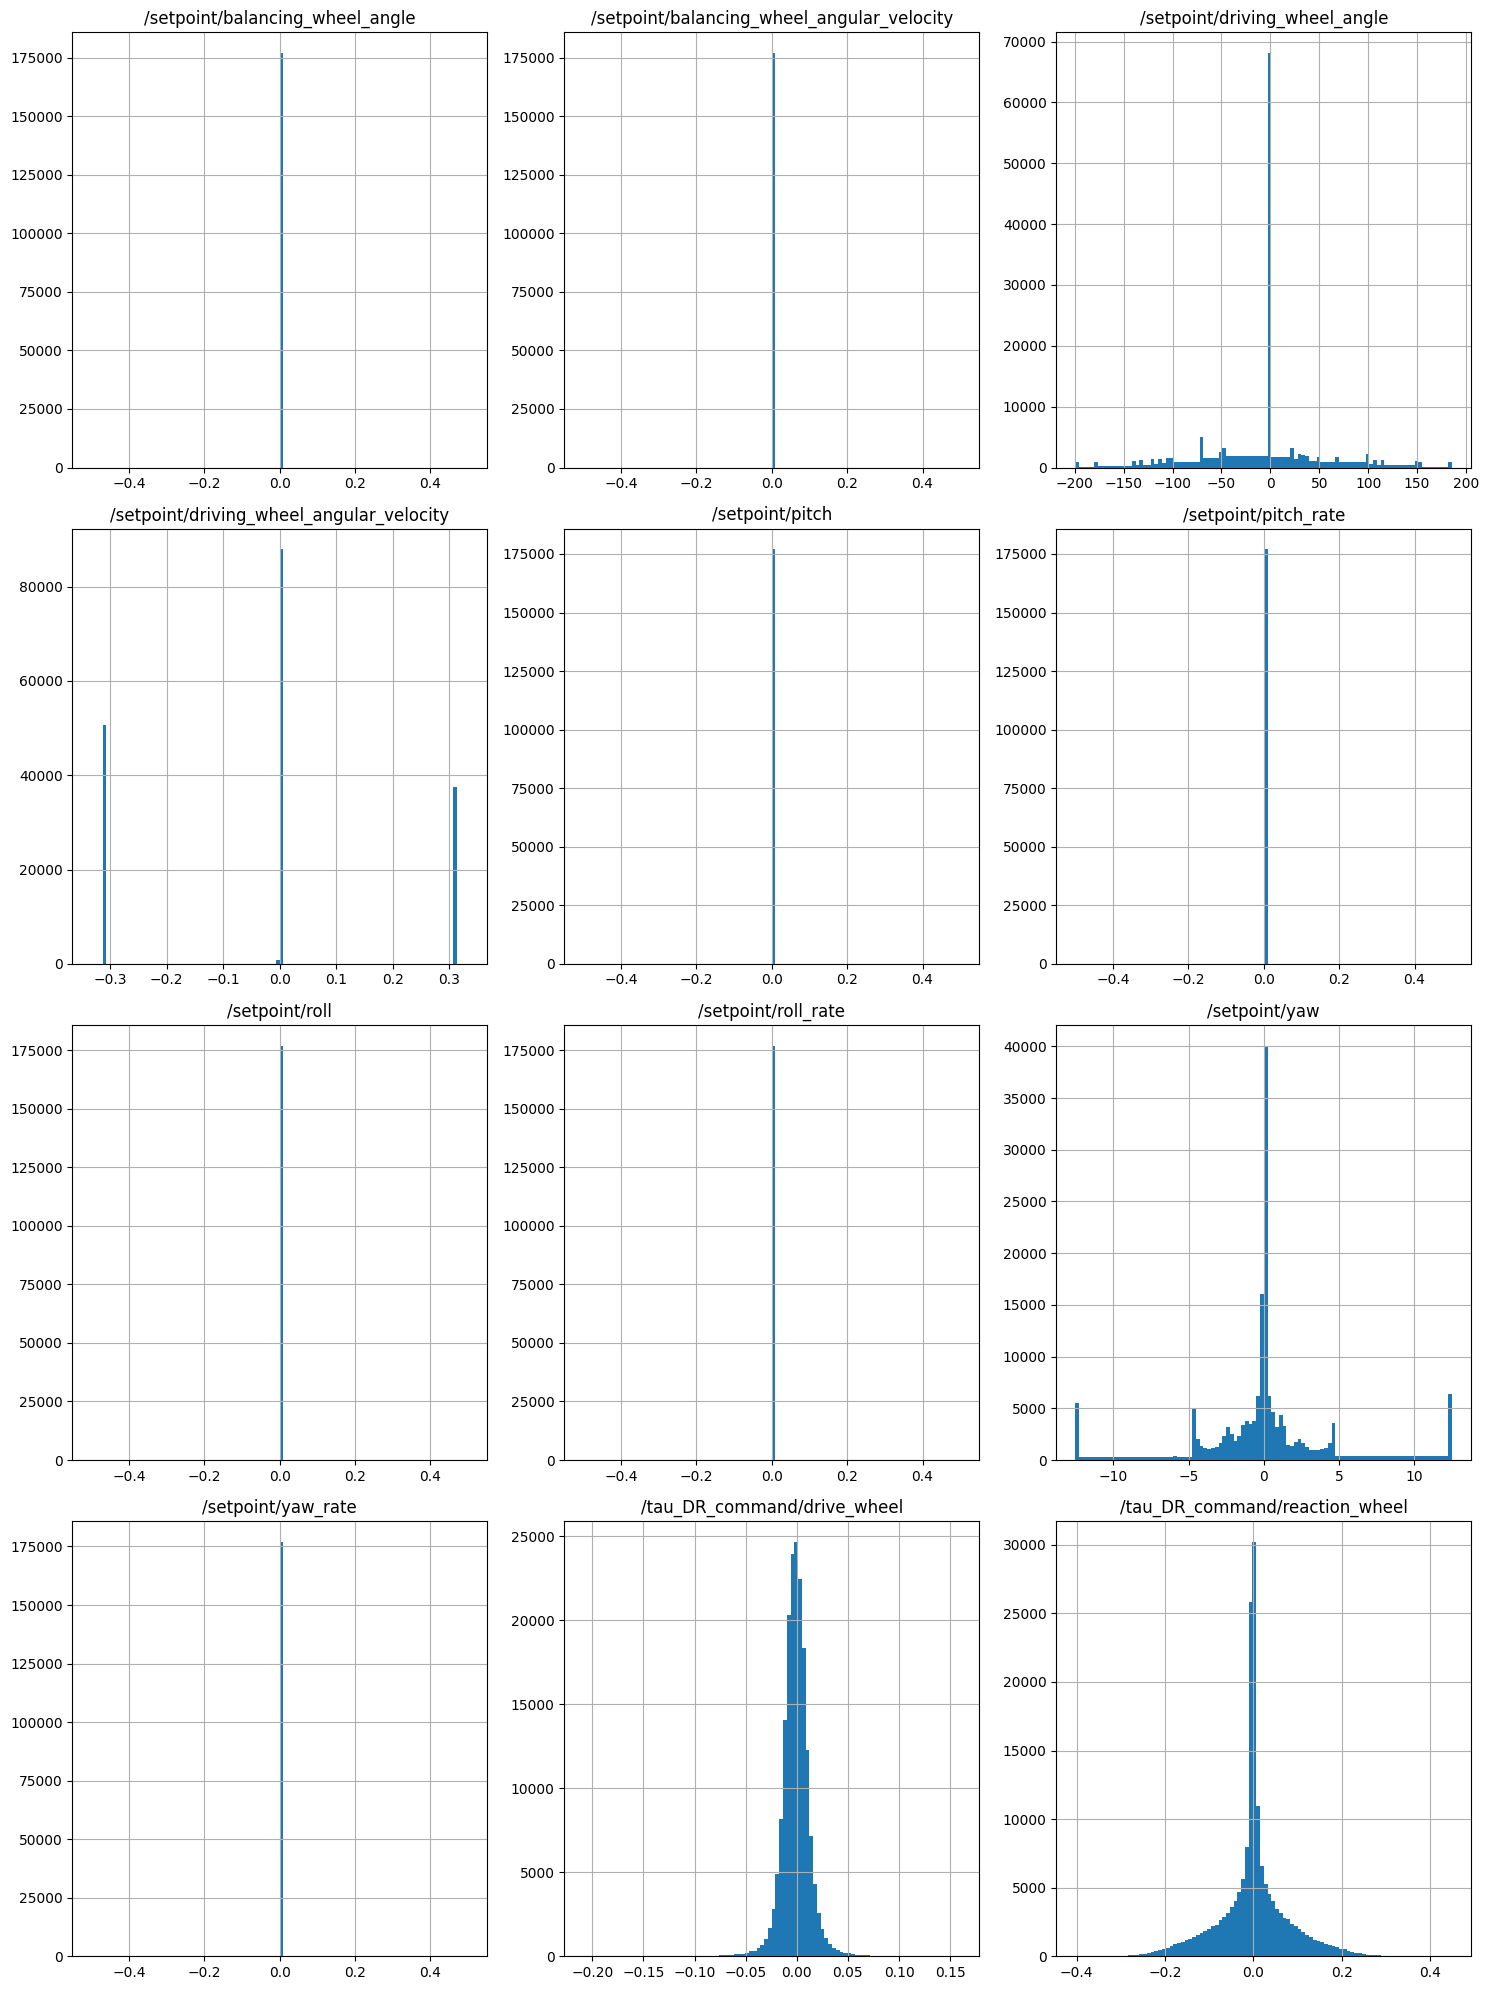

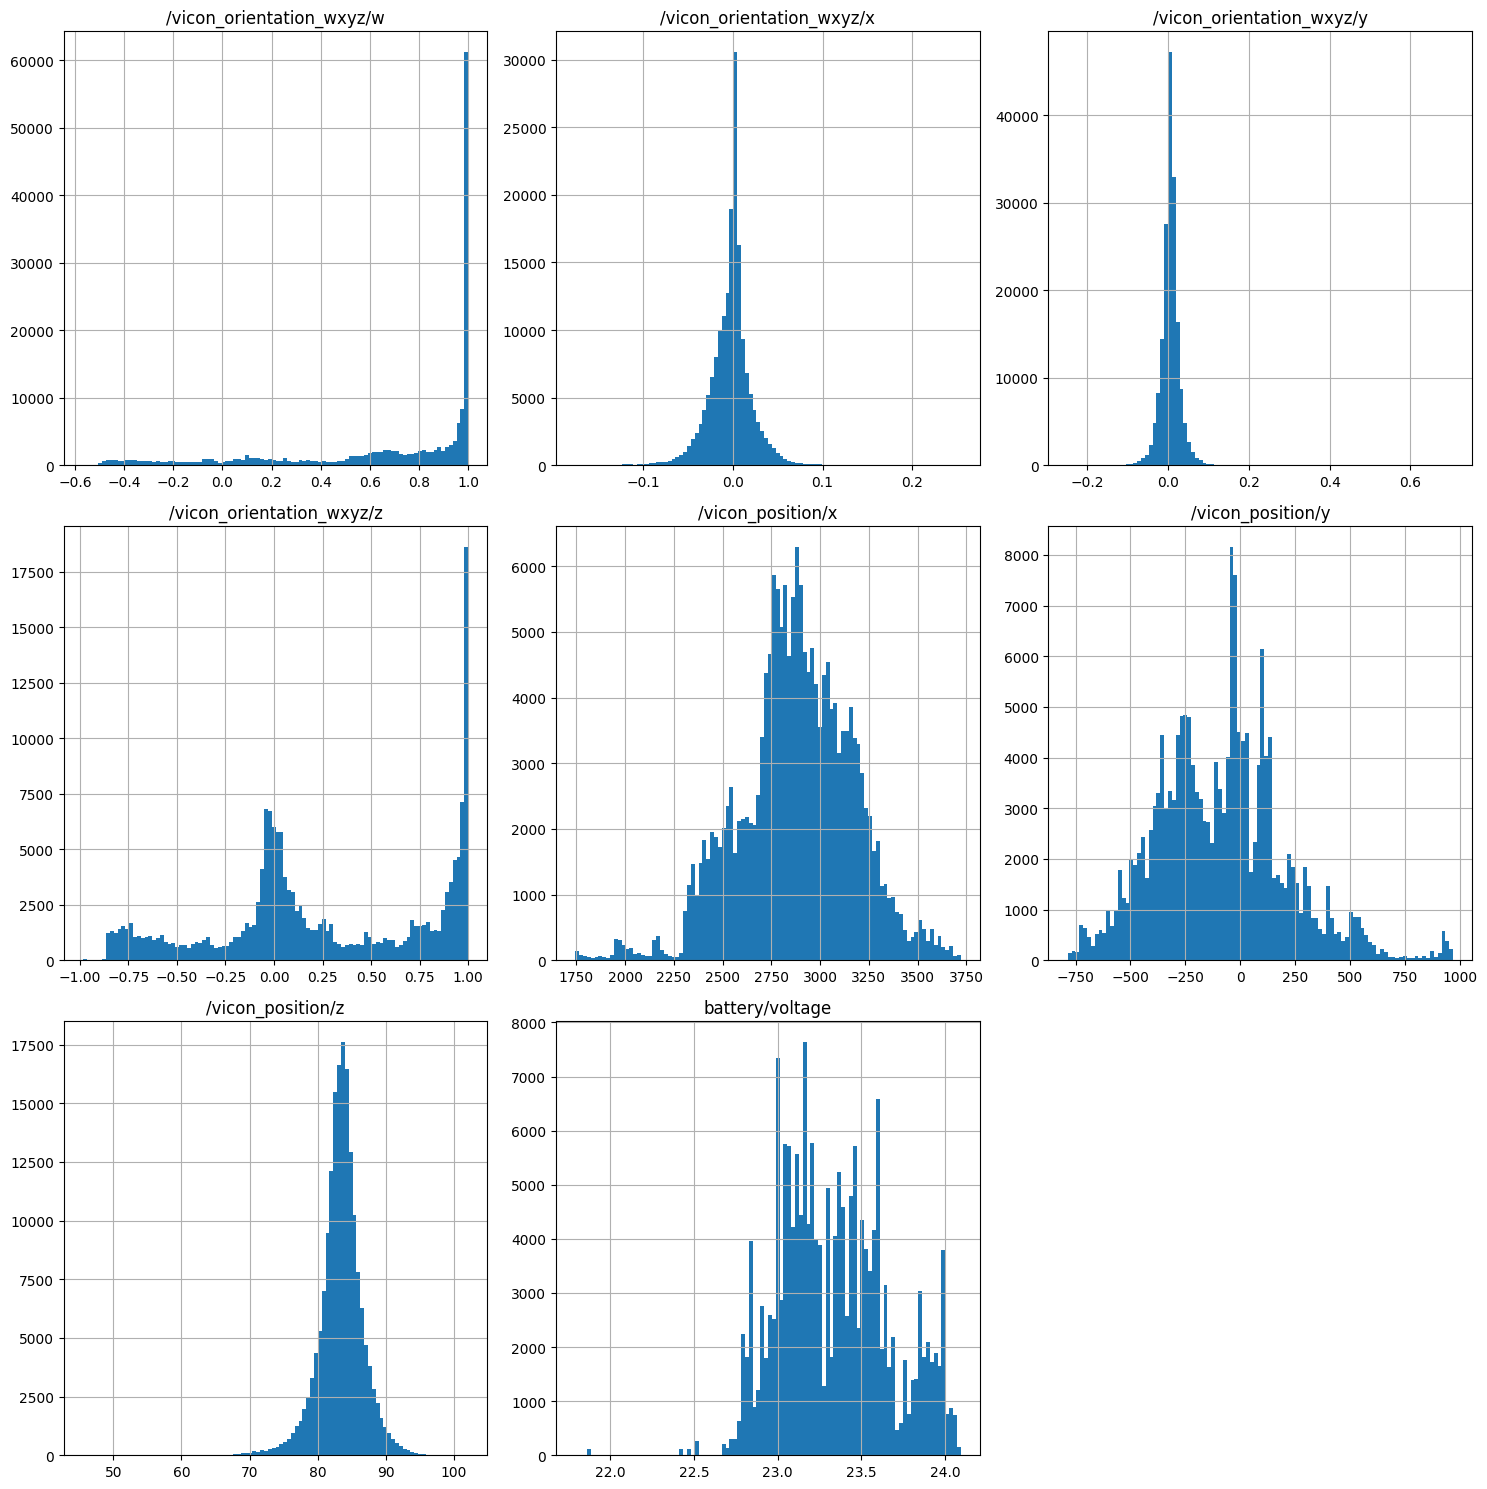

In [11]:
from wheelbot_dataset import plot_histograms

plot_histograms(data=ds_filtered, save_fig=False)

## 5. Create a dataset

Lastly, we provide thought `to_prediction_dataset` an easy-to-use API to export the filtered data to a pickle file which can then be used, e.g., to train a neural network dynamics model.


In [ ]:
from wheelbot_dataset import to_prediction_dataset


# Export an experiment to numpy (filter functions and metadata will not work anymore)
columns = ["time"] + list(exp_filtered.data.columns)
exp_numpy = exp_filtered.to_numpy(columns)
group_numpy = group_filtered.map(lambda exp: exp.to_numpy(columns))
ds_numpy = ds_filtered.map(lambda exp: exp.to_numpy(columns))

# Convert and export states, actions, nextstates for neural network training
fields_states = [
    "/q_yrp/roll",
    "/q_yrp/pitch",
    "/dq_yrp/yaw_vel",
    "/dq_yrp/roll_vel",
    "/dq_yrp/pitch_vel",
    "/dq_DR/drive_wheel",
    "/dq_DR/reaction_wheel",
]
fields_actions = [
    "/tau_DR_command/drive_wheel",
    "/tau_DR_command/reaction_wheel",
]

states, actions, nextstates, _ = to_prediction_dataset(
    ds_filtered,
    fields_states=fields_states,
    fields_actions=fields_actions,
)
print("1-step prediction dataset:")
print(f"States shape: {states.shape}")
print(f"Actions shape: {actions.shape}")
print(f"Next states shape: {nextstates.shape}")
print("\n")

# import pickle
#
# with open("dataset/dataset_1_step.pkl", "wb") as f:
#     pickle.dump(
#         {
#             "states": states,
#             "actions": actions,
#             "nextstates": nextstates,
#             "states_labels": fields_states,
#             "actions_labels": fields_actions,
#             "dt": DT,
#             "filter_type": "scipy.signal.butter",
#         },
#         f,
#     )

states, actions, nextstates, _ = to_prediction_dataset(
    ds_filtered,
    fields_states=fields_states,
    fields_actions=fields_actions,
    N_future=50,
)
print("50-step prediction dataset:")
print(f"States shape: {states.shape}")
print(f"Actions shape: {actions.shape}")
print(f"Next states shape: {nextstates.shape}")

# Save dataset as pickle
# with open("dataset/dataset_50_step.pkl", "wb") as f:
#     pickle.dump(
#         {
#             "states": states,
#             "actions": actions,
#             "nextstates": nextstates,
#             "states_labels": fields_states,
#             "actions_labels": fields_actions,
#             "dt": DT,
#             "filter_type": "scipy.signal.butter",
#         },
#         f,
#     )

1-step prediction dataset:
States shape: (176909, 1, 7)
Actions shape: (176909, 1, 2)
Next states shape: (176909, 1, 7)


50-step prediction dataset:
States shape: (174998, 1, 7)
Actions shape: (174998, 50, 2)
Next states shape: (174998, 50, 7)
